In [1]:
import warnings
warnings.filterwarnings('ignore') # to avoid warnings

import random
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer,  AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import numpy as np

In [3]:
# !pip install seaborn matplotlib torch transformers

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)


In [3]:
# 데이터 불러오기
financial_data = pd.read_csv("./stock_data_textrank_2/반도체와반도체장비_지수.csv", encoding='utf-8', index_col=0)
financial_data = financial_data[['content','label']]
financial_data.label = financial_data.label.apply(lambda x:int(x))
financial_data

,content,label
0,Some countries have offered to help Tunisia pr...,1
1,"Following that, the Fed’s most hawkish policy-...",1
2,MEXICO CITY (Reuters) -Mexican state oil compa...,1
3,New bird flu cases were detected in a commerci...,1
4,"McCarthy, 67, had initially planned to remain ...",2
...,...,...
216171,Australian police on Thursday charged a 49-yea...,0
216172,South Korean President Moon Jae-in said on Thu...,0
216173,A Philippine court on Thursday held a former b...,0
216174,Police in Vietnam have arrested a former senio...,0


In [6]:
# financial_data.label = financial_data.label.apply(lambda x:x if x >= 0 else 2 )

In [39]:
financial_data.shape

(214967, 2)

In [40]:
financial_data.label.value_counts()

1    93652
2    86678
0    34637
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

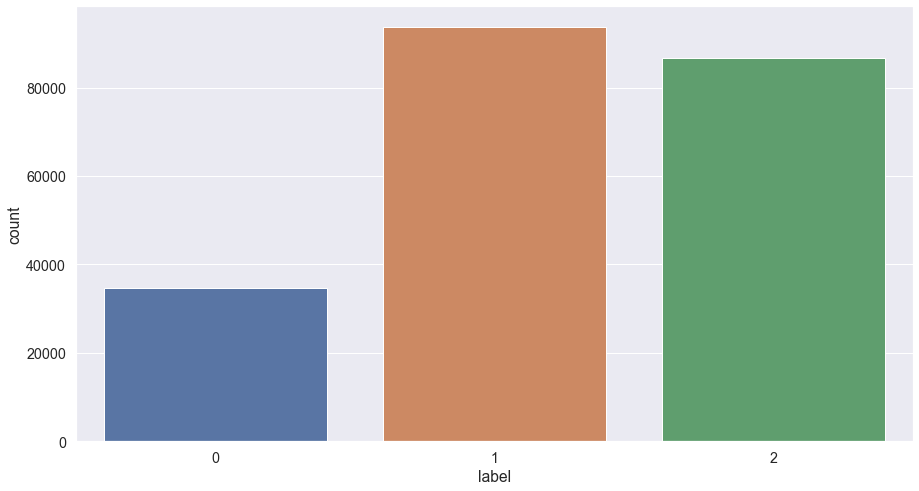

In [41]:
# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='label', data = financial_data)

In [5]:
financial_data = financial_data.sample(n=10000)

<AxesSubplot:xlabel='label', ylabel='count'>

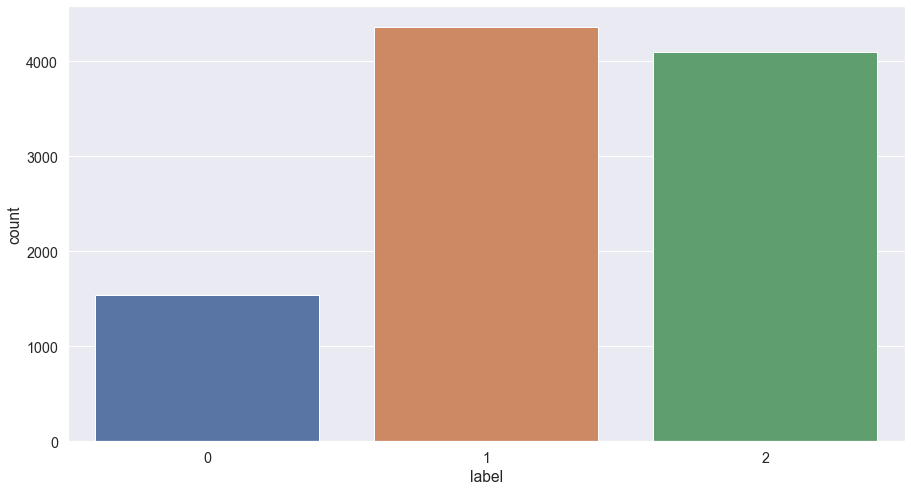

In [6]:
# Configure the plot size
plt.figure(figsize = (15,8))

sns.set(style='darkgrid')
    
# Increase information on the figure
sns.set(font_scale=1.3)
sns.countplot(x='label', data = financial_data)

In [7]:
# Create training and validation data
# train, test 나누기
x_train, x_val, y_train, y_val = train_test_split(financial_data.index.values, 
                                                  financial_data.label.values, 
                                                  test_size = 0.15, 
                                                  random_state = 2022, 
                                                  stratify = financial_data.label.values)

In [8]:
# Create the data type columns
financial_data.loc[x_train, 'data_type'] = 'train'
financial_data.loc[x_val, 'data_type'] = 'val'

# Vizualiez the number of sentiment occurence on each type of data
financial_data.groupby(['content', 'label', 'data_type']).count()

,,
content,label,data_type
"\nBy Dhirendra Tripathi\nInvesting – Ford (NYSE:F) shares rose more than 6% Thursday after the company reported higher sales in the U.S in May, riding on its SUV and electric vehicle platform with tight inventories. Ford brand retail SUVs posted best May sales since 2003, while Ranger sales recorded their best May sales since 2004. Since the bookings started last month, the automaker has received more than 70,000 reservations for its forthcoming electric vehicle F-150 Lightning.",2,train
"\nBy Dhirendra Tripathi\nInvesting.com – Shares of Covid-19 vaccine makers like BioNTech (NASDAQ:BNTX) and Moderna (NASDAQ:MRNA) weakened on Monday on prospects of one more rival, Novavax (NASDAQ:NVAX), joining them in the market. The company today, in a premarket release, said a phase-three trial had found its two-dose Covid-19 vaccine to be 90.4% effective. Pfizer (NYSE:PFE), which makes and markets the vaccine in collaboration with BioNTech, fell 1.5%.",1,train
"\nBy Yasin Ebrahim \n\nInvesting.com – The U.S. dollar was flat Tuesday as traders weighed weaker-than-expected labor data against positive remarks from Federal Reserve Chairman Jerome Powell on the economy. ""A potential shift to a looser fiscal policy stance in Germany could ultimately turn out to be more supportive for the euro further down the line,"" MUFG said in a note. The U.S. Labor Department's latest Job Openings and Labor Turnover Survey (JOLTS) report, a measure of labor demand, showed job openings in January fell to about 6.43 million, missing expectations of 7 million.",1,train
"\nInvesting.com – U.S. oil inventories fell last week, according to a private survey from the American Petroleum Institute released after the bell Wednesday.",0,train
"\nOur Senior Analyst Jesse Cohen gives us his #Top5ThingsToKnowToday in financial markets, including:\n- Apple’s Blowout Earnings\n- Tesla (NASDAQ:TSLA), Facebook (NASDAQ:FB), Microsoft (NASDAQ:MSFT) Lead Earnings Parade\n- Fed Policy Decision\n- Coronavirus News\n- Stocks Extend Gains\nFollow us on Twitter at: https://twitter.com/Investingcom",2,train
...,...,...
"• L Brands (LB) stock tumbled 7.3% as the firm reported a 3% rise in comparable store sales for the five weeks ending on July 7, slower than the 5% gain seen a month earlier. • Delta Air Lines (DAL) stock rose 1.7% as it reported quarterly adjusted earnings per diluted share of $1.77, beating estimates for $1.74. Shares remained higher despite the fact that the airline cut its full-year earnings outlook to a range of $5.35 to $5.70 per share due to an expected $2 billion higher fuel bill for 2018.",1,train
• Range Resources (NYSE:RRC) stock rose 2.54% after the company reported fourth-quarter adjusted earnings that topped consensus. • Mosaic NYSE:MOS) stock jumped 5.13% after the company reported better-than-expected quarterly results and doubled its dividend. • Tenet Healthcare (NYSE:THC) stock surged 14.78% after the company reported fourth-quarter results that beat on the top and bottom lines.,2,train
• Sprint (NYSE:S) slumped 7.2% after The Wall Street Journal reported that the Department of Justice is unlikely to approve its merger with T-Mobile (NASDAQ:TMUS) due to antitrust concerns. • Qualcomm (NASDAQ:QCOM) stock rose another 10.5% after surging 23% on Tuesday in response to its patent settlement with Apple (NASDAQ:AAPL). • Netflix (NASDAQ:NFLX) stock rose 2.5% after the streaming company added a record number of subscribers in the first quarter.,2,train


In [46]:
financial_data

,content,label,data_type
30008,Economists had forecast the core PPI increasin...,1,train
161032,"Gou, Taiwan's richest person with a net worth ...",2,val
89496,Germany's Europe minister Werner\nHoyer told H...,0,train
49814,"Norway's $930 billion sovereign wealth fund, t...",2,train
109279,By Ross Kerber\n(Reuters) -New York pension of...,2,train
...,...,...,...
62974,The Canadian dollar fell against its U.S. coun...,1,train
208719,Italy's ruling 5-Star Movement has suggested u...,2,train
108721,But with President Barack Obama's vow to push ...,1,train
82637,"The dollar slipped on\nThursday, surrendering ...",0,train


In [57]:
def get_headlines_len(df):
    
    headlines_sequence_lengths = []
    
    print("Encoding in progress...")
    for headline in tqdm(financial_data.content):
        encoded_headline = finbert_tokenizer.encode(headline, add_special_tokens = True)
        
        # record the length of the encoded review
        headlines_sequence_lengths.append(len(encoded_headline))
    print("End of Task.")
    
    return headlines_sequence_lengths

In [28]:
headlines_sequence_lengths = get_headlines_len(financial_data)

Encoding in progress...


100%|█████████████████████████████████████████████████████████████████████████| 216176/216176 [06:12<00:00, 580.53it/s]

End of Task.


In [36]:
np.mean(headlines_sequence_lengths)

113.91682240396713

In [39]:
np.percentile(headlines_sequence_lengths, 90)

159.0

(array([4.8250e+03, 8.6980e+03, 1.5037e+04, 1.5359e+04, 2.2750e+04,
        3.3883e+04, 4.9342e+04, 3.7892e+04, 1.6417e+04, 5.7920e+03,
        2.6010e+03, 1.3210e+03, 5.7200e+02, 3.5100e+02, 2.2000e+02,
        1.6000e+02, 1.1700e+02, 1.0300e+02, 8.9000e+01, 6.8000e+01,
        5.9000e+01, 5.9000e+01, 6.5000e+01, 4.3000e+01, 4.5000e+01,
        3.4000e+01, 3.9000e+01, 2.7000e+01, 2.1000e+01, 2.5000e+01,
        4.0000e+01, 4.3000e+01, 1.5000e+01, 8.0000e+00, 1.1000e+01,
        1.4000e+01, 5.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

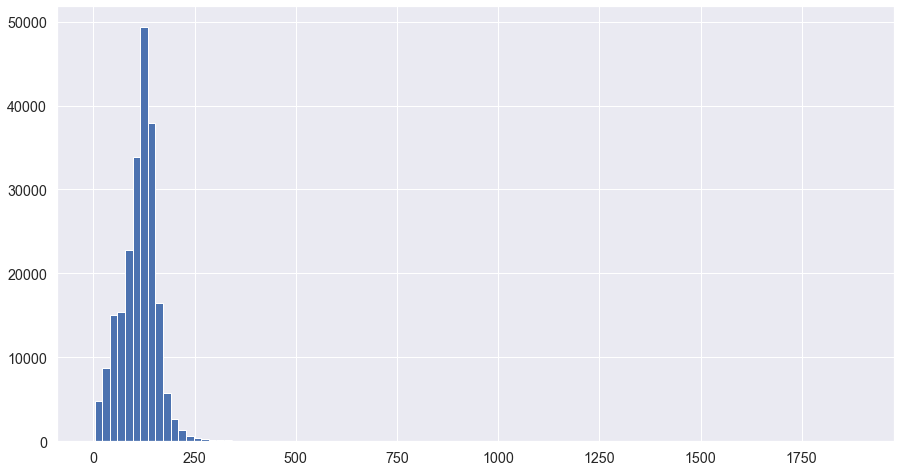

In [34]:
plt.figure(figsize = (15,8))
plt.hist(headlines_sequence_lengths, bins=100)

In [9]:
# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='train'].content.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=160 # the maximum lenght observed in the headlines
)

encoded_data_val = finbert_tokenizer.batch_encode_plus(
    financial_data[financial_data.data_type=='val'].content.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=160 # the maximum lenght observed in the headlines
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(financial_data[financial_data.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
sentiments_val = torch.tensor(financial_data[financial_data.data_type=='val'].label.values)


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, sentiments_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=3,
                                                          output_attentions=False,
                                                          output_hidden_states=False)

In [12]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)

epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    labels_dict = {"neutral":0,"positive":1,"negative":2}
    
    label_dict_inverse = {v: k for k, v in labels_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals



# Model

In [54]:
# 모델
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./epoch_20/Text_Rank_반도체_finBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Epoch 1:  24%|████████████▍                                      | 65/266 [09:15<28:31,  8.51s/it, training_loss=0.311]


Epoch 1:  49%|████████████████████████▌                         | 131/266 [18:39<19:19,  8.59s/it, training_loss=0.333]


Epoch 1:  74%|█████████████████████████████████████             | 197/266 [28:03<09:52,  8.58s/it, training_loss=0.394]


Epoch 1:  99%|█████████████████████████████████████████████████▍| 263/266 [37:27<00:25,  8.50s/it, training_loss=0.367]


  0%|                                                                                           | 0/20 [37:50<?, ?it/s]


Epoch 1
Training loss: 1.0201443572689717


  5%|███▉                                                                          | 1/20 [40:10<12:43:13, 2410.19s/it]

Validation loss: 1.0191643060521876
F1 Score (Weighted): 0.27895440892512335



Epoch 2:  24%|████████████▍                                      | 65/266 [09:22<28:33,  8.53s/it, training_loss=0.347]


Epoch 2:  49%|████████████████████████▌                         | 131/266 [18:43<19:03,  8.47s/it, training_loss=0.358]


Epoch 2:  74%|█████████████████████████████████████             | 197/266 [28:05<09:45,  8.48s/it, training_loss=0.312]


Epoch 2:  99%|█████████████████████████████████████████████████▍| 263/266 [37:27<00:25,  8.53s/it, training_loss=0.306]


  5%|███▊                                                                        | 1/20 [1:17:51<12:43:13, 2410.19s/it]


Epoch 2
Training loss: 0.9972779616377407


 10%|███████▌                                                                    | 2/20 [1:20:11<12:01:29, 2404.95s/it]

Validation loss: 1.0474741775938805
F1 Score (Weighted): 0.34602805810360177



Epoch 3:  24%|████████████▍                                      | 65/266 [09:18<28:20,  8.46s/it, training_loss=0.345]


Epoch 3:  49%|████████████████████████▌                         | 131/266 [18:36<19:05,  8.48s/it, training_loss=0.292]


Epoch 3:  74%|█████████████████████████████████████             | 197/266 [27:55<09:44,  8.47s/it, training_loss=0.309]


Epoch 3:  99%|█████████████████████████████████████████████████▍| 263/266 [37:13<00:25,  8.46s/it, training_loss=0.320]


 10%|███████▌                                                                    | 2/20 [1:57:39<12:01:29, 2404.95s/it]


Epoch 3
Training loss: 0.9273120778843873


 15%|███████████▍                                                                | 3/20 [1:59:58<11:19:05, 2396.78s/it]

Validation loss: 1.0943989766404985
F1 Score (Weighted): 0.3920465583002257



Epoch 4:  24%|████████████▍                                      | 65/266 [08:54<26:57,  8.05s/it, training_loss=0.265]


Epoch 4:  49%|████████████████████████▌                         | 131/266 [18:15<19:24,  8.63s/it, training_loss=0.237]


Epoch 4:  74%|█████████████████████████████████████             | 197/266 [27:46<09:55,  8.63s/it, training_loss=0.269]


Epoch 4:  99%|█████████████████████████████████████████████████▍| 263/266 [37:16<00:25,  8.65s/it, training_loss=0.288]


 15%|███████████▍                                                                | 3/20 [2:37:29<11:19:05, 2396.78s/it]


Epoch 4
Training loss: 0.8152969557988016


 20%|███████████████▏                                                            | 4/20 [2:39:51<10:38:44, 2395.28s/it]

Validation loss: 1.1870586973555544
F1 Score (Weighted): 0.3910339021417752



Epoch 5:  24%|████████████▍                                      | 65/266 [09:28<28:45,  8.59s/it, training_loss=0.195]


Epoch 5:  49%|████████████████████████▌                         | 131/266 [18:54<19:22,  8.61s/it, training_loss=0.220]


Epoch 5:  74%|█████████████████████████████████████             | 197/266 [28:28<10:07,  8.81s/it, training_loss=0.277]


Epoch 5:  99%|█████████████████████████████████████████████████▍| 263/266 [37:58<00:25,  8.59s/it, training_loss=0.267]


 20%|███████████████▏                                                            | 4/20 [3:18:04<10:38:44, 2395.28s/it]


Epoch 5
Training loss: 0.6918491636003766


 25%|███████████████████                                                         | 5/20 [3:20:25<10:02:20, 2409.40s/it]

Validation loss: 1.2898087526889557
F1 Score (Weighted): 0.4045092088411086



Epoch 6:  24%|████████████▍                                      | 65/266 [09:28<28:43,  8.58s/it, training_loss=0.171]


Epoch 6:  49%|████████████████████████▌                         | 131/266 [18:55<19:24,  8.63s/it, training_loss=0.206]


Epoch 6:  74%|█████████████████████████████████████             | 197/266 [28:23<09:52,  8.58s/it, training_loss=0.208]


Epoch 6:  99%|█████████████████████████████████████████████████▍| 263/266 [37:51<00:25,  8.62s/it, training_loss=0.234]


 25%|███████████████████                                                         | 5/20 [3:58:33<10:02:20, 2409.40s/it]


Epoch 6
Training loss: 0.5812950053609404


 30%|███████████████████████                                                      | 6/20 [4:00:54<9:23:41, 2415.85s/it]

Validation loss: 1.409433366136348
F1 Score (Weighted): 0.40238793926015404



Epoch 7:  24%|████████████▍                                      | 65/266 [09:27<28:45,  8.59s/it, training_loss=0.225]


Epoch 7:  49%|████████████████████████▌                         | 131/266 [18:54<19:20,  8.60s/it, training_loss=0.156]


Epoch 7:  74%|█████████████████████████████████████             | 197/266 [28:23<09:52,  8.59s/it, training_loss=0.223]


Epoch 7:  99%|█████████████████████████████████████████████████▍| 263/266 [37:50<00:25,  8.63s/it, training_loss=0.107]


 30%|███████████████████████                                                      | 6/20 [4:38:59<9:23:41, 2415.85s/it]


Epoch 7
Training loss: 0.4839902134766256


 35%|██████████████████████████▉                                                  | 7/20 [4:41:21<8:44:13, 2419.46s/it]

Validation loss: 1.5381451781759872
F1 Score (Weighted): 0.38987602852842956



Epoch 8:  24%|████████████▍                                      | 65/266 [09:28<28:49,  8.60s/it, training_loss=0.126]


Epoch 8:  49%|████████████████████████▌                         | 131/266 [18:55<19:28,  8.65s/it, training_loss=0.163]


Epoch 8:  74%|█████████████████████████████████████             | 197/266 [28:27<09:53,  8.60s/it, training_loss=0.155]


Epoch 8:  99%|█████████████████████████████████████████████████▍| 263/266 [37:54<00:25,  8.60s/it, training_loss=0.123]


 35%|██████████████████████████▉                                                  | 7/20 [5:19:30<8:44:13, 2419.46s/it]


Epoch 8
Training loss: 0.3966442874275652


 40%|██████████████████████████████▊                                              | 8/20 [5:21:51<8:04:35, 2422.99s/it]

Validation loss: 1.695450800530454
F1 Score (Weighted): 0.3844265960134497



Epoch 9:  24%|████████████▍                                      | 65/266 [09:26<28:52,  8.62s/it, training_loss=0.173]


Epoch 9:  49%|████████████████████████▌                         | 131/266 [18:54<19:18,  8.58s/it, training_loss=0.093]


Epoch 9:  74%|█████████████████████████████████████             | 197/266 [28:25<09:55,  8.63s/it, training_loss=0.102]


Epoch 9:  99%|█████████████████████████████████████████████████▍| 263/266 [37:51<00:25,  8.56s/it, training_loss=0.088]


 40%|██████████████████████████████▊                                              | 8/20 [5:59:58<8:04:35, 2422.99s/it]


Epoch 9
Training loss: 0.3341713341835298


 45%|██████████████████████████████████▋                                          | 9/20 [6:02:19<7:24:30, 2424.59s/it]

Validation loss: 1.8174365860350588
F1 Score (Weighted): 0.386760817395807



Epoch 10:  24%|████████████▏                                     | 65/266 [09:26<28:36,  8.54s/it, training_loss=0.049]


Epoch 10:  49%|████████████████████████▏                        | 131/266 [18:52<19:23,  8.62s/it, training_loss=0.080]


Epoch 10:  74%|████████████████████████████████████▎            | 197/266 [28:19<09:54,  8.61s/it, training_loss=0.096]


Epoch 10:  99%|████████████████████████████████████████████████▍| 263/266 [37:46<00:25,  8.57s/it, training_loss=0.089]


 45%|██████████████████████████████████▋                                          | 9/20 [6:40:20<7:24:30, 2424.59s/it]


Epoch 10
Training loss: 0.2741103917360306


 50%|██████████████████████████████████████                                      | 10/20 [6:42:42<6:43:58, 2423.86s/it]

Validation loss: 1.9191621922432107
F1 Score (Weighted): 0.40150372268007184



Epoch 11:  24%|████████████▏                                     | 65/266 [09:28<28:50,  8.61s/it, training_loss=0.069]


Epoch 11:  49%|████████████████████████▏                        | 131/266 [18:48<17:53,  7.95s/it, training_loss=0.068]


Epoch 11:  74%|████████████████████████████████████▎            | 197/266 [27:36<09:29,  8.26s/it, training_loss=0.072]


Epoch 11:  99%|████████████████████████████████████████████████▍| 263/266 [36:54<00:25,  8.41s/it, training_loss=0.108]


 50%|██████████████████████████████████████                                      | 10/20 [7:19:51<6:43:58, 2423.86s/it]


Epoch 11
Training loss: 0.22887327691498108


 55%|█████████████████████████████████████████▊                                  | 11/20 [7:22:10<6:01:00, 2406.76s/it]

Validation loss: 2.037006195555342
F1 Score (Weighted): 0.39670750052260134



Epoch 12:  24%|████████████▏                                     | 65/266 [09:15<28:08,  8.40s/it, training_loss=0.079]


Epoch 12:  49%|████████████████████████▏                        | 131/266 [18:42<19:08,  8.51s/it, training_loss=0.063]


Epoch 12:  74%|████████████████████████████████████▎            | 197/266 [28:01<09:44,  8.47s/it, training_loss=0.062]


Epoch 12:  99%|████████████████████████████████████████████████▍| 263/266 [37:19<00:25,  8.45s/it, training_loss=0.088]


 55%|█████████████████████████████████████████▊                                  | 11/20 [7:59:43<6:01:00, 2406.76s/it]


Epoch 12
Training loss: 0.19333126181666566


 60%|█████████████████████████████████████████████▌                              | 12/20 [8:02:02<5:20:18, 2402.37s/it]

Validation loss: 2.165951764329951
F1 Score (Weighted): 0.3841617629682146



Epoch 13:  24%|████████████▏                                     | 65/266 [09:20<28:21,  8.46s/it, training_loss=0.015]


Epoch 13:  49%|████████████████████████▏                        | 131/266 [18:40<19:01,  8.45s/it, training_loss=0.028]


Epoch 13:  74%|████████████████████████████████████▎            | 197/266 [27:59<09:44,  8.47s/it, training_loss=0.069]


Epoch 13:  99%|████████████████████████████████████████████████▍| 263/266 [37:22<00:25,  8.42s/it, training_loss=0.042]


 60%|█████████████████████████████████████████████▌                              | 12/20 [8:39:39<5:20:18, 2402.37s/it]


Epoch 13
Training loss: 0.15779593248004303


 65%|█████████████████████████████████████████████████▍                          | 13/20 [8:41:58<4:40:02, 2400.35s/it]

Validation loss: 2.285562961659533
F1 Score (Weighted): 0.39196954695948655



Epoch 14:  24%|████████████▏                                     | 65/266 [09:14<28:00,  8.36s/it, training_loss=0.034]


Epoch 14:  49%|████████████████████████▏                        | 131/266 [18:29<18:53,  8.40s/it, training_loss=0.039]


Epoch 14:  74%|████████████████████████████████████▎            | 197/266 [27:42<09:42,  8.44s/it, training_loss=0.016]


Epoch 14:  99%|████████████████████████████████████████████████▍| 263/266 [37:01<00:25,  8.43s/it, training_loss=0.050]


 65%|█████████████████████████████████████████████████▍                          | 13/20 [9:19:13<4:40:02, 2400.35s/it]


Epoch 14
Training loss: 0.13882178286636682


 70%|█████████████████████████████████████████████████████▏                      | 14/20 [9:21:32<3:59:15, 2392.54s/it]

Validation loss: 2.400291473307508
F1 Score (Weighted): 0.38313351633825277



Epoch 15:  24%|████████████▏                                     | 65/266 [09:10<28:01,  8.37s/it, training_loss=0.030]


Epoch 15:  49%|████████████████████████▏                        | 131/266 [18:21<18:44,  8.33s/it, training_loss=0.018]


Epoch 15:  74%|████████████████████████████████████▎            | 197/266 [27:32<09:35,  8.35s/it, training_loss=0.028]


Epoch 15:  99%|████████████████████████████████████████████████▍| 263/266 [36:43<00:25,  8.34s/it, training_loss=0.020]


 70%|█████████████████████████████████████████████████████▏                      | 14/20 [9:58:30<3:59:15, 2392.54s/it]


Epoch 15
Training loss: 0.11677085998979278


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [10:00:48<3:18:28, 2381.60s/it]

Validation loss: 2.5026734636185015
F1 Score (Weighted): 0.3845161537869144



Epoch 16:  24%|████████████▏                                     | 65/266 [09:05<27:39,  8.26s/it, training_loss=0.008]


Epoch 16:  49%|████████████████████████▏                        | 131/266 [18:12<18:35,  8.26s/it, training_loss=0.028]


Epoch 16:  74%|████████████████████████████████████▎            | 197/266 [27:18<09:30,  8.26s/it, training_loss=0.035]


Epoch 16:  99%|████████████████████████████████████████████████▍| 263/266 [36:23<00:24,  8.27s/it, training_loss=0.045]


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [10:37:26<3:18:28, 2381.60s/it]


Epoch 16
Training loss: 0.10525403863617352


 80%|████████████████████████████████████████████████████████████               | 16/20 [10:39:45<2:37:52, 2368.09s/it]

Validation loss: 2.660299486302315
F1 Score (Weighted): 0.3663955336447875



Epoch 17:  24%|████████████▏                                     | 65/266 [09:05<27:34,  8.23s/it, training_loss=0.034]


Epoch 17:  49%|████████████████████████▏                        | 131/266 [18:09<18:29,  8.22s/it, training_loss=0.042]


Epoch 17:  74%|████████████████████████████████████▎            | 197/266 [27:14<09:27,  8.23s/it, training_loss=0.030]


Epoch 17:  99%|████████████████████████████████████████████████▍| 263/266 [36:19<00:24,  8.28s/it, training_loss=0.060]


 80%|████████████████████████████████████████████████████████████               | 16/20 [11:16:19<2:37:52, 2368.09s/it]


Epoch 17
Training loss: 0.10100537535027229


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [11:18:37<1:57:52, 2357.34s/it]

Validation loss: 2.6644428587974387
F1 Score (Weighted): 0.3791683140176327



Epoch 18:  24%|████████████▏                                     | 65/266 [09:03<27:52,  8.32s/it, training_loss=0.005]


Epoch 18:  49%|████████████████████████▏                        | 131/266 [18:08<18:29,  8.22s/it, training_loss=0.009]


Epoch 18:  74%|████████████████████████████████████▎            | 197/266 [27:12<09:30,  8.27s/it, training_loss=0.012]


Epoch 18:  99%|████████████████████████████████████████████████▍| 263/266 [36:16<00:24,  8.28s/it, training_loss=0.016]


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [11:55:08<1:57:52, 2357.34s/it]


Epoch 18
Training loss: 0.08847042366414141


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [11:57:26<1:18:17, 2348.82s/it]

Validation loss: 2.7062042520401324
F1 Score (Weighted): 0.37737680166905313



Epoch 19:  24%|████████████▏                                     | 65/266 [09:02<27:35,  8.24s/it, training_loss=0.011]


Epoch 19:  49%|████████████████████████▏                        | 131/266 [18:06<18:26,  8.19s/it, training_loss=0.011]


Epoch 19:  74%|████████████████████████████████████▎            | 197/266 [27:10<09:29,  8.25s/it, training_loss=0.036]


Epoch 19:  99%|████████████████████████████████████████████████▍| 263/266 [36:13<00:24,  8.22s/it, training_loss=0.024]


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [12:33:54<1:18:17, 2348.82s/it]


Epoch 19
Training loss: 0.07983651028988056


 95%|█████████████████████████████████████████████████████████████████████████▏   | 19/20 [12:36:12<39:01, 2341.89s/it]

Validation loss: 2.7411537880593158
F1 Score (Weighted): 0.38060877849698826



Epoch 20:  24%|████████████▏                                     | 65/266 [09:04<27:38,  8.25s/it, training_loss=0.021]


Epoch 20:  49%|████████████████████████▏                        | 131/266 [18:08<18:30,  8.23s/it, training_loss=0.063]


Epoch 20:  74%|████████████████████████████████████▎            | 197/266 [27:11<09:28,  8.23s/it, training_loss=0.016]


Epoch 20:  99%|████████████████████████████████████████████████▍| 263/266 [36:16<00:24,  8.23s/it, training_loss=0.024]


 95%|█████████████████████████████████████████████████████████████████████████▏   | 19/20 [13:12:42<39:01, 2341.89s/it]


Epoch 20
Training loss: 0.07615706365191399


100%|█████████████████████████████████████████████████████████████████████████████| 20/20 [13:15:02<00:00, 2385.12s/it]

Validation loss: 2.761435587355431
F1 Score (Weighted): 0.37540033294044944


# Test

In [15]:
# Load the best model & Make Predictions

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",
                                                          num_labels=3,
                                                          output_attentions=False,
                                                          output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('./Text_Rank_반도체_finBERT_epoch_20.model', 
                                 map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals)

Class: neutral
Accuracy: 42/232

Class: positive
Accuracy: 266/654

Class: negative
Accuracy: 326/614



In [16]:
preds = predictions
labels = true_vals

labels_dict = {"neutral":0,"positive":1,"nagative":2}

label_dict_inverse = {v: k for k, v in labels_dict.items()}

preds_flat = np.argmax(preds, axis=1).flatten()
labels_flat = labels.flatten()
    
for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
# 점수 산정 부분
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('acc', accuracy_score(labels_flat, preds_flat))
print('precision', precision_score(labels_flat, preds_flat,average='macro'))
print('recall', recall_score(labels_flat, preds_flat,average='macro'))
print('f1', f1_score(labels_flat, preds_flat,average='macro'))


Class: neutral
Accuracy: 42/232

Class: positive
Accuracy: 266/654

Class: nagative
Accuracy: 326/614

acc 0.4226666666666667
precision 0.3799098897075444
recall 0.37290231230398807
f1 0.3725832952464369


In [17]:
result_data = pd.read_csv('./0422_textrank.csv', index_col=0)
result_data

# Get the FinBERT Tokenizer
finbert_tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", do_lower_case=True)

# Encode the Training and Validation Data
encoded_data_train = finbert_tokenizer.batch_encode_plus(
    result_data.content.values, 
    return_tensors='pt',
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=160 # the maximum lenght observed in the headlines
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']



dataset_val = TensorDataset(input_ids_train, attention_masks_train)


# 요부분 빠졌더라
batch_size = 5

# dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)

result_d = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

model.eval()
result = []
for batch in result_d:

    batch = tuple(b.to(device) for b in batch)

    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1],
#               'labels':         batch[2],
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    print(outputs)
    result.append(outputs)

FileNotFoundError: [Errno 2] No such file or directory: './0422_textrank.csv'

In [67]:
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from collections import Counter
font_path = 'C:\Windows\Fonts\ALGER.TTF'

cm = ['Set1','Accent','Dark2']

icon = Image.open('./ss.png')    # 마스크가 될 이미지 불러오기 
# plt.imshow(icon)

# palettes = 'Dark2'
mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)

wordcloud = WordCloud(
    font_path = font_path,
    width = 1000,
    height= 1000,
    background_color= 'white',
    colormap=cm[2],
    mask=mask
)
count = Counter(keywords[2])
wordcloud = wordcloud.generate_from_frequencies(count)

def __array__(self):
    return self.to_array()

def to_array(self):
    return np.array(self.to_image())

array = wordcloud.to_array()
plt.figure(figsize=(5,15))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [68]:
!pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for wordcloud
Failed to build wordcloud
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [20 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.10
  creating build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\color_from_image.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\tokenization.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\wordcloud.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\wordcloud_cli.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\_version.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\__init__.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\__main__.py -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\stopwords -> build\lib.win-amd64-3.10\wordcloud
  copying wordcloud\DroidSansMono.ttf -> build\lib.win-amd64-3.10\wordcloud
  UPDATING build\lib.win-amd64-3.10\wordcloud/_version